In [ ]:
import numpy as np
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)


X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_train /= 255
X_test /= 255

enc = OneHotEncoder(handle_unknown='ignore')
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) 
print(y_train_one_hot.shape) 
print(y_train_one_hot.dtype) 

(60000,)
(60000, 10)
float64


In [ ]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("X_train: ", X_train_.shape) 
print("X_val: ", X_val.shape)  
print("y_train: ", y_train_.shape) 
print("y_val: ", y_val.shape)

X_train:  (48000, 784)
X_val:  (12000, 784)
y_train:  (48000, 10)
y_val:  (12000, 10)


In [ ]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20)
for mini_X_train, mini_y_train in get_mini_batch:
    mini_X_train, mini_y_train
mini_X_train = mini_X_train.reshape(20, 1, 28, 28)

In [ ]:
class SimpleInitializer:
    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self,f_num, Chanel, f_size_h, f_size_w):
        np.random.seed(0)
        self.W = self.sigma * np.random.randn(f_num, Chanel, f_size_h, f_size_w)
        return self.W
    
    def B(self, f_num):
        np.random.seed(0)
        self.B = self.sigma * np.random.randn(f_num,1)
        return self.B

In [ ]:
class XavierInitializer:
    
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
        
    def W(self,f_num, Chanel, f_size_h, f_size_w):
        self.sigma = (1 / np.sqrt(f_num))
        np.random.seed(0)
        self.W = self.sigma * np.random.randn(f_num, Chanel, f_size_h, f_size_w)
        return self.W
        
    def B(self,f_num):
        np.random.seed(0)
        self.sigma = (1 / np.sqrt(f_num))
        self.B = self.sigma * np.random.randn(f_num,1)
        return self.B

In [ ]:
class He:
    
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
    
    def W(self, f_num, Chanel, f_size_h, f_size_w):
        sigma = np.sqrt(2 / 1)
        np.random.seed(0)
        self.W = sigma * np.random.randn(f_num, Chanel, f_size_h, f_size_w)
        return self.W
        
    def B(self,f_num):
        sigma = np.sqrt(2 / 1)
        np.random.seed(0)
        self.B = sigma * np.random.randn(f_num,1)
        return self.B

In [ ]:
class SGD:

    def __init__(self, lr=0.001):
        self.lr = lr
        
    def update(self,layer):

        layer.W -= (self.lr * layer.dW)
        layer.B -= (self.lr * layer.dB)
        return layer.W, layer.B

In [ ]:
def output_heigh_calculation(X_h,pad_n,F_h,stride):
    output_h = (X_h + 2*pad_n - F_h)//stride + 1
    return output_h

In [ ]:
def output_width_calculation(X_w,pad_n,F_w,stride):
    output_w = (X_w + 2*pad_n - F_w)//stride + 1
    return output_w

In [ ]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = output_heigh_calculation(X_h=H,pad_n=pad, F_h=filter_h, stride=stride)
    out_w = output_width_calculation(X_w=W,pad_n=pad, F_w=filter_w, stride=stride)
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [ ]:
def col2im(col, X, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = X.shape
    out_h = output_heigh_calculation(X_h=H,pad_n=pad, F_h=filter_h, stride=stride)
    out_w = output_width_calculation(X_w=W,pad_n=pad, F_w=filter_w, stride=stride)
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [ ]:
class Conv2D:
    def __init__(self, n_filter, f_size, initializer, optimizer, activation, p =1, stride=1, n_channel_in = 1, n_channel_out= 1, debug = False):
        self.init = initializer
        self.optimizer = optimizer
        self.n_channel_in = n_channel_in
        self.n_channel_out = n_channel_out
        self.stride = stride
        self.pad = p
        self.n_out = None
        self.f_size = f_size
        self.activate = activation
        self.n_filter = n_filter
        self.debug = debug
    
    def forward(self, X):
        
        self.n_samples, channels, im_rows, im_col = X.shape
        
        channels = self.n_channel_in
        #X = X.reshape(self.n_samples, self.n_channel_in, im_rows, im_col)
        
        self.X = X
        # initialization of weights and biases
        self.w = self.init.W((self.n_filter, self.n_channel_in, self.f_size, self.f_size))
        self.b = self.init.B((self.n_filter,))
        
        
        self.n_out_row = num_out(im_rows, self.pad, self.f_size, self.stride)
        self.n_out_col = num_out(im_col, self.pad, self.f_size, self.stride)

        result = np.zeros((self.n_samples, self.n_filter, self.n_out_row, self.n_out_col), dtype=np.float64)
        
        # padding of samples and kernel
        nx = im_rows + self.f_size - 1
        ny = im_col + self.f_size - 1

        #self.x_new = np.pad(X, ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)), mode="constant")
        self.x_new = np.pad(X, ((0, 0), (0, 0), (0, nx - im_rows), (0, ny - im_col)), mode="constant")
        self.w_new = np.pad(self.w, ((0, 0), (0, 0), (0, nx - self.f_size), (0, ny - self.f_size)), mode="constant")

        # loops through samples of images

        """convolution theorem states that under suitable conditions 
        the Fourier transform of a convolution of two functions (or signals) 
        is the pointwise product of their Fourier transforms."""

        for i in range(self.n_samples):
            for f in range(self.n_filter):
                for ch in range(channels):
                    for row in range(0, self.n_out_row, self.stride):
                        row_n = row + self.f_size
                        if row + row_n > im_rows:
                            break
                        for col in range(0, self.n_out_col, self.stride):
                            col_n = col + self.f_size
                            if col_n + col > im_col:
                                break   
                                              
                            result[i, f, row, col] = np.sum(self.x_new[i, ch, row:row_n, col: col_n] * self.w[f, ch]) + self.b[f]
                            

        # for i in range(self.n_samples):
        #     sample = self.x_new[i]
        #     for ch in range(channels):
        #         channel = np.fft.fft2(sample[ch])
        #         weight = np.conj(np.fft.fft2(self.w_new[:, ch])) 
                      
        #         s = self.f_size - 2
        #         out = np.fft.ifft2(channel * weight)
        #         out = np.real(out)[:, s:-s:self.stride, s:-s:self.stride]
                
        #         out += self.b
                
        #         result[i] = out
                
        if self.debug == True:
            return result
        
        return self.activate.forward(result)
    
    def backward(self, dA, debug = False):
        
        
        if debug == False:
            dZ = dA
        else:
            dZ = self.activate.backward(dA)

        n_samples, n_filter, height, width = dA.shape
        x = self.x_new
        _, _, XH, XW = x.shape
        s = self.stride
        f_size = self.f_size
        Nh, Nw = num_out(XH, 0, height, s), num_out(XW, 0, width, s)
        
        a = 0
        dw = np.zeros((n_samples, n_filter, f_size, f_size))
        #self.dB = np.sum(dA, dtype=np.float_, axis=(0, 2, 3))
        dB = np.zeros_like(self.b)
        for i in range(n_samples):
            for f in range(n_filter):
                for ch in range(self.n_channel_in):
                    dB[ch] = np.sum(dA[:, ch, :, :])
                    for h in range(Nh):
                        h_i = h * s # index going through image height at a given stride
                        h_n = h_i + height # height range selected by filter
                        if h_i + h > Nh:
                            break
                        for w in range(Nw):
                            w_i = w * s # index going through image height at a given stride
                            w_n = w_i + width # height range selected by filter
                            if w_n + w > Nw:
                                break

                            dw[i, f, h, w] = np.sum(x[i, ch, h_i:h_n, w_i:w_n] * dA[i, f])
                   
        self.dW = dw.sum(0)[:, np.newaxis, :, :]
        self.dB = dB

        
        weights = self.w
        dZ = np.pad(dZ, ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)))
        samp, filt, rows, cols = dZ.shape
        dx = np.zeros_like(dZ)
        
        for i in range(samp):
            for f in range(filt):
                    for row in range(0, rows, s): 
                        row_n = row + f_size
                        if row_n + row > rows:
                            break
                        for col in range(0, cols, s):
                            col_n = col + f_size
                            if col_n + col > cols:
                                break
                            
                            dx[i, :, row: row_n, col:col_n] += weights[f, :, :, :] * dZ[i, f, row, col]
        
        self.optimizer.update(self)
        return dx



## Problem 3

def num_out(n_in, pad, f, s):
    """
    ##### self.n_in: number of features
    ##### pad: Number of padding on one side
    ##### s: stride value

    ##### Returns: Number of output of convolution
    """
    n_out = ((n_in + 2*pad - f)/ s) +1
    return int(n_out)


In [ ]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr 
        self.HW = 1
        self.HB = 1

    def update(self, layer):

        self.HW += layer.dW**2
        self.HB += layer.dB**2

        layer.w -= self.lr * np.sqrt(1/self.HW) * (layer.dW)
        layer.b -= self.lr * np.sqrt(1/self.HB) *  layer.dB


class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        The weight or bias of a certain layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """

        layer.w -= self.lr * layer.dW
        layer.b -= self.lr * layer.dB

In [ ]:
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])


class Initialize:
    def __init__(self,)-> None:
            pass
    
    def W(self, shape):
          
          w = np.array([[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]],

              [[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]])
          return w[:, np.newaxis, :, :]

    def B(self, shape):
          return np.zeros(*shape)

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

 = Conv2D(2, 3, Initialize(), SGD(0.01), Tanh())

data = CNN2.forward(x)

CNN2.backward(data)

array([[[[ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        , -1.76092346,  0.76159416,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.9993293 ,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        , -1.76092346,  0.76159416,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.9993293 ,  0.        ,
           0.        ,  0.        ],
        

Problem 5

In [ ]:
class MaxPool2D():
    def __init__(self, P):
        self.P = P
        self.PA = None
        self.Pindex = None
    
    def forward(self,A):
        N,F,OH,OW = A.shape
        PH,PW = int(OH/self.P),int(OW/self.P)
        self.params = N,F,OH,OW,self.P,PH,PW
        self.PA = np.zeros([N,F,PH,PW])
        self.Pindex = np.zeros([N,F,PH,PW])
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        self.PA[n,ch,row,col] = np.max(A[n,ch,row*self.P:row*self.P+self.P,col*self.P:col*self.P+self.P])
                        self.Pindex[n,ch,row,col] = np.argmax(A[n,ch,row*self.P:row*self.P+self.P,col*self.P:col*self.P+self.P])
        return self.PA
    
    def backward(self,dA):
        
        N,F,OH,OW,PS,PH,PW = self.params
        
        dP = np.zeros([N,F,OH,OW])
        for n in range(N): 
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        idx = self.Pindex[n,ch,row,col]
                        tmp = np.zeros((PS*PS))
                        
                        for i in range(PS*PS):
                            if i == idx:
                                
                                tmp[i] = dA[n,ch,row,col]
                            else:
                                tmp[i] = 0
                        dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
        return dP

Problem 6

In [ ]:
class Flatten:
    def __init__(self):
        pass
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(self.shape[0], -1)
    
    def backward(self,X):
        return X.reshape(self.shape) 

In [ ]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activator):
        self.optimizer = optimizer
        self.w = initializer.W((n_nodes1, n_nodes2))
        self.b = initializer.B((n_nodes2,))
        self.activator = activator
        
        
    
    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """        
        self.Z = X
        A = X @ self.w + self.b
        
        return self.activator.forward(A)
    
    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        dA = self.activator.backward(dA)
        # update
        self.dB = np.sum(dA, axis=0)

       # print(self.dB)
        self.dW = self.Z.T @ dA 
        self.dZ = dA @ self.w.T
        
        self.optimizer.update(self)
        
        return self.dZ

In [ ]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, shape):
        """
        Weight initialization
        Parameters
        ----------
        Shape: tuple
        Returns
        ----------
        W :
        """
        w = self.sigma * np.random.randn(*shape)
        
        return w
    
    def B(self, shape):
        """
        Bias initialization
        Parameters
        ----------
        shape : tuple
          Number of nodes in the later layer

        Returns
        ----------
        B :
        """
        B = np.zeros(*shape)
        return B

In [ ]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr 
        self.HW = 1
        self.HB = 1

    def update(self, layer):

        self.HW += layer.dW**2
        self.HB += layer.dB**2

        layer.w -= self.lr * np.sqrt(1/self.HW) * (layer.dW)
        layer.b -= self.lr * np.sqrt(1/self.HB) *  layer.dB


class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        The weight or bias of a certain layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """

        layer.w -= self.lr * layer.dW
        layer.b -= self.lr * layer.dB
    

In [ ]:
class Flatten:

    def forward(self, x):
        N, C, H, W = x.shape
        out = x.reshape(N, -1)        
        self.x = x        
        return out
    
    def backward(self, dout):
        dx = dout.reshape(self.x.shape)      
        return dx

In [ ]:
class Relu:
    def __init__(self) -> None:
        pass

    def forward(self, X):
        self.A = X
        return np.clip(X, 0, None)
    
    def backward(self, X):
        a = X > 0
        return X * np.clip(np.sign(self.A), 0, None)

class Softmax():
        def __init__(self) -> None:
            pass


        def forward(self, a):
            numerator = np.exp(a)
            self.dZ = numerator / np.sum(np.exp(a), axis=1, keepdims=True).reshape(-1, 1)
            
            return self.dZ
        
        def backward(self, Y):
             self.loss = self.loss_func(Y)   
                      
             return self.dZ - Y
        
        def loss_func(self, Y, Z = None):             
            if type(Z) == type(None):
                Z = self.dZ
            
            loss = -1* np.sum(Y * np.log(Z + 1e-7))

            return loss/len(Y)


In [ ]:

class GetMiniBatch:
    """
Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int_)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [ ]:
class  ScratchConvolutionalNeuralNetwork2D:
    def __init__(self, NN, CNN, epoch=20, batch_size=20, verbose = False):
        self.epoch = epoch
        self.NN = NN
        self.CNN = CNN
        self.batch_size = batch_size
        self.verbose = verbose
        self.log_loss = np.zeros(self.batch_size)
        self.log_acc = np.zeros(self.batch_size)

        
    def loss_function(self, y, yt):
        delta = 1e-7
        loss = -1 * np.sum(yt * np.log(y + delta))

        #print(yt.shape)
        #print(y)
        return loss / len(yt)
    

    def accuracy(self,Z,Y):
        return accuracy_score(Y,Z)

    def fit(self, X, y, x_val = None, y_val= None):
        for epoch in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            self.loss = 0
            for mini_x_train, mini_y_train in get_mini_batch:
                # forward propagation
                forward_data = mini_x_train
                
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                flt = Flatten()
                forward_data = flt.forward(forward_data)
                
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)

                z = forward_data
                        
                
            backward_data = (z- mini_y_train)/ self.batch_size
            layers = len(self.NN) - 1
            for layer in range(len(self.NN)):
                backward_data = self.NN[layers - layer].backward(backward_data)
            
            backward_data = flt.backward(backward_data)

            layers = len(self.CNN) - 1
            for layer in range(len(self.CNN)):
                backward_data = self.CNN[layers - layer].backward(backward_data)
            
            self.loss += self.loss_function(z, mini_y_train)

            self.log_loss[epoch] = self.loss / self.batch_size
            self.log_acc[epoch] = self.accuracy(self.predict(X), np.argmax(y, axis=1))
            if self.verbose:
                print(self.loss/self.batch_size,self.accuracy(self.predict(X),np.argmax(y,axis=1)))

        return self

    def predict(self, X):
        pred_data = X[:, :, :]
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
            
        pred_data = Flatten().forward(pred_data)
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)

        return np.argmax(pred_data,axis=1)

In [ ]:
class HeInitializer:
    def __init__(self, n):
        """
        n: Length of dataset
        """
        
        self.sigma = (2 / n) ** 0.5
        
    
    def W(self, nodes):
        return np.random.normal(0, self.sigma, nodes)
    
    def B(self, nodes):
        return np.random.normal(0, self.sigma, nodes)

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train.astype(np.float_), x_test.astype(np.float_)
x_train /= 255
x_test /= 255

onv = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
one_hot_y_train = onv.fit_transform(y_train[:, np.newaxis])
#one_hot_y_test = onv.fit_transform(y_test[:, np.newaxis])

x_train, x_val, y_train, y_val = train_test_split(x_train, one_hot_y_train, test_size=0.7)

x_train = x_train[:300][:, np.newaxis, :, :]
y_train = y_train[:300]
y_test = y_test[:300]


print(x_train.shape)

(300, 1, 28, 28)


Problem 7

In [ ]:
NN = {
    0:FC(1960, 200, HeInitializer(1960), AdaGrad(0.01), Relu()),
    1:FC(200, 200, HeInitializer(200), AdaGrad(0.01), Relu()),
    2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
}

CNN = {
    0: Conv2D(n_filter=10, n_channel_in=1, f_size=3, p=1, stride=1 ,initializer=SimpleInitializer(0.01),optimizer=SGD(0.01), activation = Relu()),
    1: MaxPool2D(2),
}

model = ScratchConvolutionalNeuralNetwork2D(NN=NN, CNN=CNN, epoch=10).fit(x_train, y_train)

In [ ]:
plt.plot(model.log_loss)

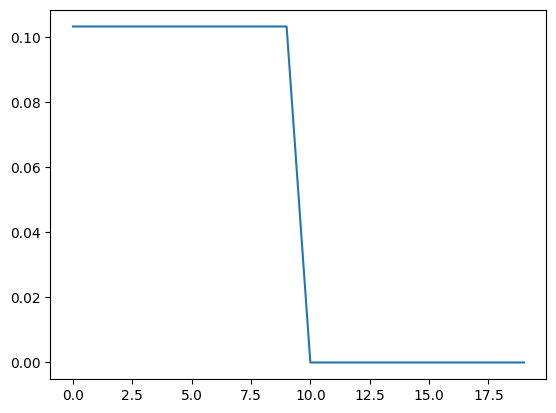

In [ ]:
plt.plot(model.log_acc)

Problem 8

In [ ]:
NN = {
    0:FC(400, 120, HeInitializer(1960), AdaGrad(0.01), Relu()),
    1:FC(120, 84, HeInitializer(200), AdaGrad(0.01), Relu()),
    2:FC(84, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
}

CNN = {
    0: Conv2D(n_filter=6, n_channel_in=1, f_size=5, p=1, stride=1 ,initializer=SimpleInitializer(0.01),optimizer=SGD(0.01), activation = Relu()),
    1: MaxPool2D(2),
    2: Conv2D(n_filter=16, n_channel_in=1, f_size=5, p=1, stride=1 ,initializer=SimpleInitializer(0.01),optimizer=SGD(0.01), activation = Relu()),
    3: MaxPool2D(2),
}


model = ScratchConvolutionalNeuralNetwork2D(NN=NN, CNN=CNN, epoch=10).fit(x_train, y_train)

#(20, 16, 11, 11)

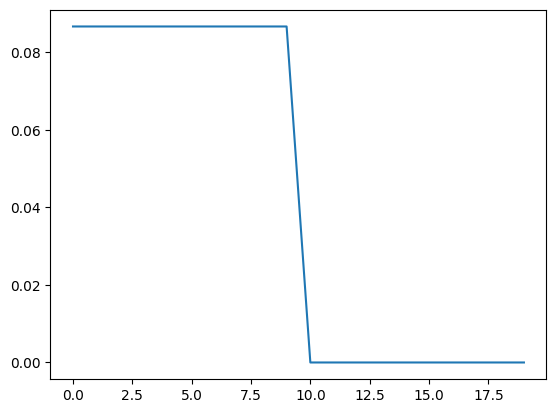

In [ ]:
plt.plot(model.log_acc)

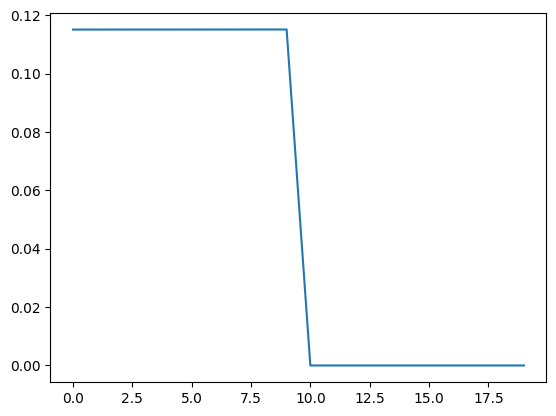

In [ ]:
plt.plot(model.log_loss)

Problme 9

AlexNet (2012):
1. Developed by Alex Krizhevsky et al. in 2012.
2. Achieved breakthrough performance in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012, significantly surpassing previous methods.
3. Introduced key components like ReLU activation functions, dropout for regularization, and overlapping pooling.
4. Had a relatively deep architecture for its time, with stacked convolutional and pooling layers followed by fully connected layers for classification.
VGG16 (2014):
1. Proposed by Karen Simonyan and Andrew Zisserman in 2014.
2. Built upon the success of AlexNet, focusing on a simpler architecture with only 3x3 convolutional filters with a stride of 1 and padding to preserve spatial information.
3. Increased the depth of the network significantly compared to AlexNet, using multiple stacked 3x3 convolutional layers.
4. Achieved even better accuracy than AlexNet on ILSVRC 2014.


Problem 10

Input size : 144 x 144, 3 channels
Filter size: 3 x 3, 6 channels
Stride : 1
Padding: none

In [ ]:
output_rows = num_out(144, 0, 3, 1)

output_cols = num_out(144, 0, 3, 1)

output_shape = (6, output_rows, output_cols)
output_shape

(6, 142, 142)

Input size : 60x60, 24 channels
Filter size: 3 x 3, 48 channels
Stride : 1
Padding: none

In [ ]:
output_rows = num_out(60, 0, 3, 1)

output_cols = num_out(60, 0, 3, 1)

output_shape = (48, output_rows, output_cols)
output_shape

(48, 58, 58)

Input size : 20x20, 10 channels
Filter size: 3 x 3, 20 channels
Stride : 2
Padding: none

In [ ]:
output_rows = num_out(20, 0, 3, 2)

output_cols = num_out(20, 0, 3, 2)

output_shape = (20, output_rows, output_cols)
output_shape

(20, 9, 9)

3 x 3 filter size is commonly used over larger ones such as 7 x 7 to preserve spatial information. Large filters can lead to information loss.